# About Problem: HR Analytics

HR analytics is revolutionising the way human resources departments operate, leading to higher efficiency and better results overall. Human resources has been using analytics for years. However, the collection, processing and analysis of data has been largely manual, and given the nature of human resources dynamics and HR KPIs, the approach has been constraining HR. Therefore, it is surprising that HR departments woke up to the utility of machine learning so late in the game. Here is an opportunity to try predictive analytics in identifying the employees most likely to get promoted.

# Problem Statement

Your client is a large MNC and they have 9 broad verticals across the organisation. One of the problem your client is facing is around identifying the right people for promotion (only for manager position and below) and prepare them in time. Currently the process, they are following is:

    They first identify a set of employees based on recommendations/ past performance
    Selected employees go through the separate training and evaluation program for each vertical. These programs are based on the required skill of each vertical
    At the end of the program, based on various factors such as training performance, KPI completion (only employees with KPIs completed greater than 60% are considered) etc., employee gets promotion

For above mentioned process, the final promotions are only announced after the evaluation and this leads to delay in transition to their new roles. Hence, company needs your help in identifying the eligible candidates at a particular checkpoint so that they can expedite the entire promotion cycle. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier

from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_csv('train_LZdllcl.csv')
test = pd.read_csv('test_2umaH9m.csv')
submission = pd.read_csv('sample_submission_M0L0uXE.csv')
train.shape, test.shape

((54808, 14), (23490, 13))

In [3]:
train.sample(5)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
43716,34740,Sales & Marketing,region_10,Bachelor's,m,other,6,31,1.00,7,0,0,55,0
51463,37981,Analytics,region_27,Bachelor's,m,other,1,32,3.00,6,1,0,83,0
39852,10701,Analytics,region_2,NaN,m,other,1,24,nan,1,0,0,84,0
48687,18375,Finance,region_7,Bachelor's,m,other,1,31,5.00,7,1,0,62,0
19563,68659,Operations,region_2,Bachelor's,m,other,1,50,2.00,11,1,0,67,0


In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
employee_id,54808.00,39195.83,22586.58,1.00,19669.75,39225.50,58730.50,78298.00
no_of_trainings,54808.00,1.25,0.61,1.00,1.00,1.00,1.00,10.00
age,54808.00,34.80,7.66,20.00,29.00,33.00,39.00,60.00
previous_year_rating,50684.00,3.33,1.26,1.00,3.00,3.00,4.00,5.00
length_of_service,54808.00,5.87,4.27,1.00,3.00,5.00,7.00,37.00
KPIs_met >80%,54808.00,0.35,0.48,0.00,0.00,0.00,1.00,1.00
awards_won?,54808.00,0.02,0.15,0.00,0.00,0.00,0.00,1.00
avg_training_score,54808.00,63.39,13.37,39.00,51.00,60.00,76.00,99.00
is_promoted,54808.00,0.09,0.28,0.00,0.00,0.00,0.00,1.00


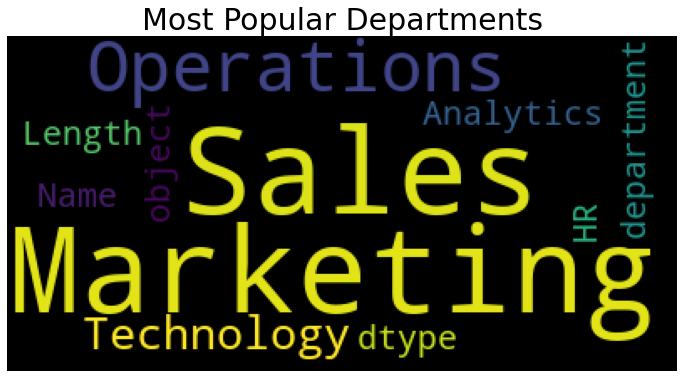

In [5]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color='black', stopwords=stopwords).generate(str(train['department']))
plt.figure(figsize=(12, 8))
print(wordcloud)
plt.imshow(wordcloud)
plt.title('Most Popular Departments', fontsize = 30)
plt.axis('off')
plt.show()

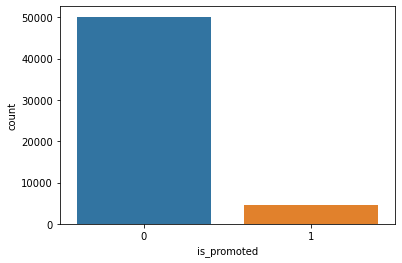

In [6]:
sns.countplot(train['is_promoted']);

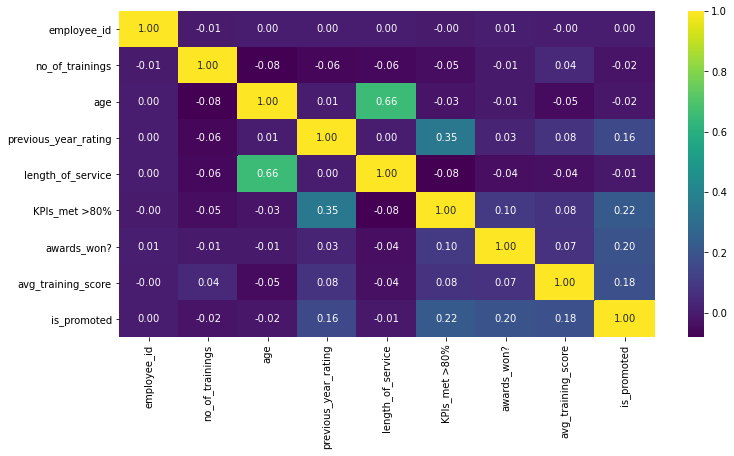

In [7]:
plt.figure(figsize=(12,6))
sns.heatmap(train.corr(), annot=True, fmt='.2f', cmap='viridis')

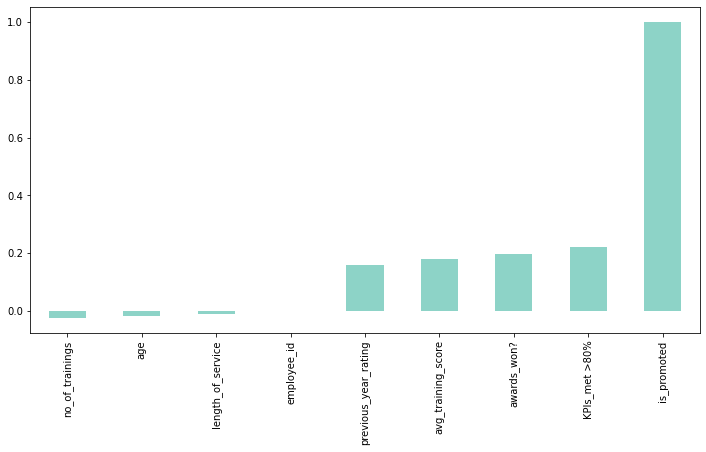

In [8]:
plt.figure(figsize=(12,6))
train.corr()['is_promoted'].sort_values().plot(kind='bar', cmap='Set3')

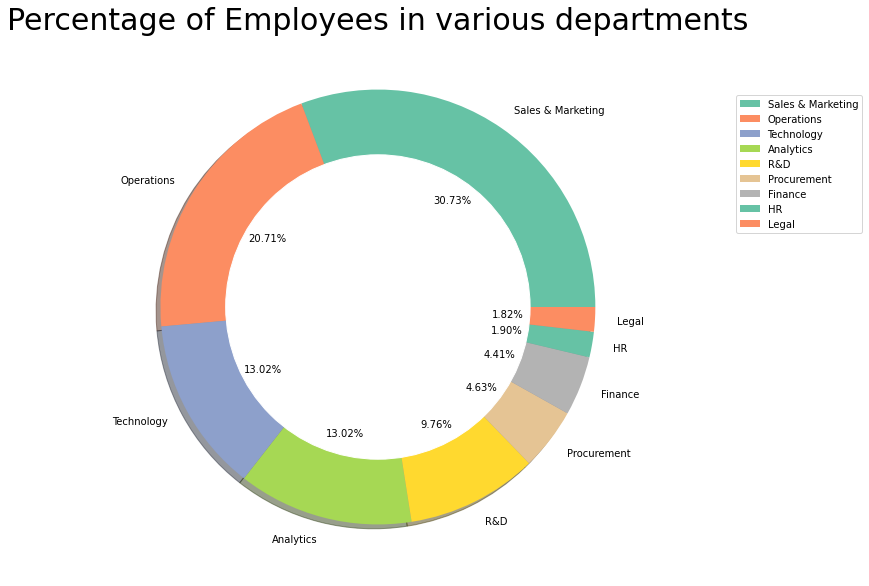

In [9]:
size = train['department'].value_counts()
labels = train['department'].unique()
colors = plt.cm.Set2(np.linspace(0,1,7))

plt.figure(figsize=(10,10))
circle = plt.Circle((0, 0), radius=0.7, color='white')
plt.pie(size, colors = colors, labels = labels, shadow = True, autopct = '%.2f%%')
p = plt.gcf()
p.gca().add_artist(circle)
plt.title('Percentage of Employees in various departments', fontsize=30)
plt.legend(bbox_to_anchor=(0.5, 0., 0.9, 0.9));

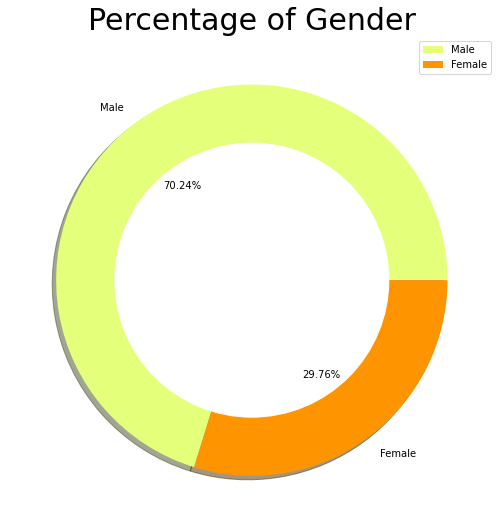

In [10]:
size = train['gender'].value_counts()
labels = ['Male', 'Female']
colors = plt.cm.Wistia(np.linspace(0,5,7))

plt.figure(figsize=(9,9))
circle = plt.Circle((0, 0), radius=0.7, color='white')
plt.pie(size, colors = colors, labels = labels, shadow = True, autopct = '%.2f%%')
p = plt.gcf()
p.gca().add_artist(circle)
plt.title('Percentage of Gender', fontsize=30)
plt.legend();

In [11]:
train['education'].unique()

array(["Master's & above", "Bachelor's", nan, 'Below Secondary'],
      dtype=object)

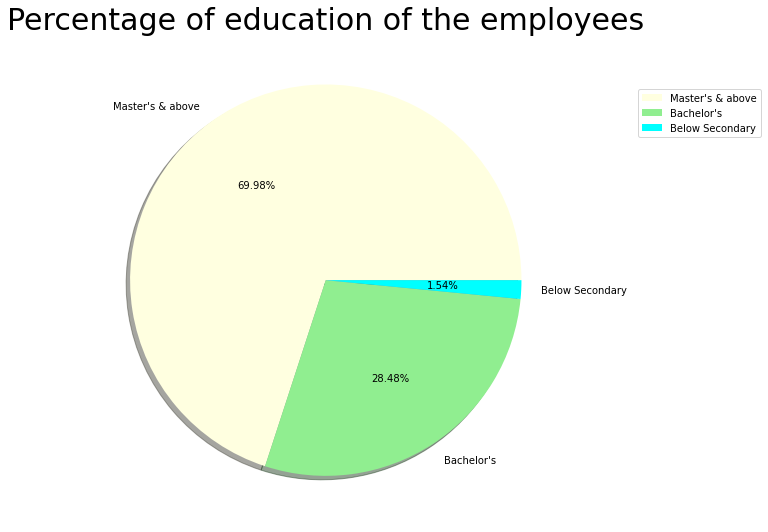

In [12]:
size = train['education'].value_counts()
labels = ["Master's & above", "Bachelor's", 'Below Secondary']
colors = ['lightyellow', 'lightgreen', 'cyan']

plt.figure(figsize=(9,9))
plt.pie(size, colors = colors, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Percentage of education of the employees', fontsize=30)
plt.legend(bbox_to_anchor=(0.5, 0., 0.9, 0.9))
plt.show()

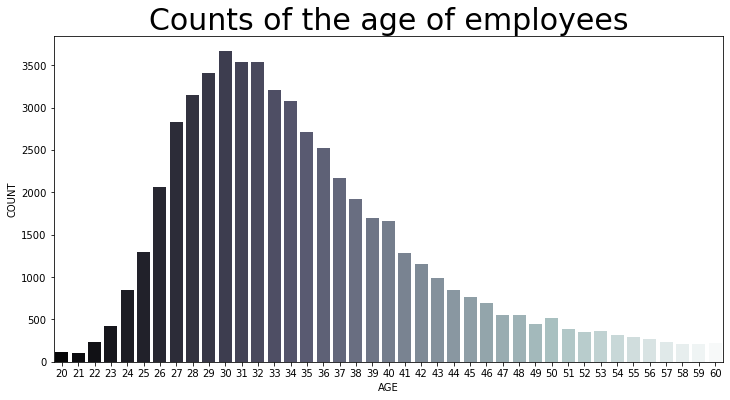

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(train['age'], palette='bone')
plt.title('Counts of the age of employees', fontsize=30)
plt.xlabel('AGE')
plt.ylabel('COUNT')
plt.show()

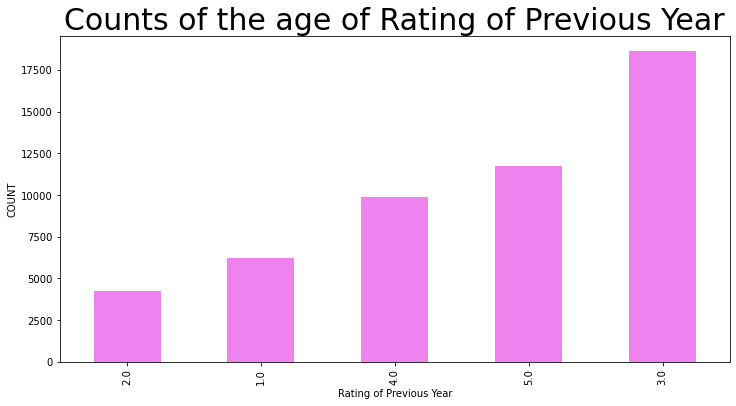

In [14]:
plt.figure(figsize=(12, 6))
train['previous_year_rating'].value_counts().sort_values().plot(kind='bar', color='violet')
plt.title('Counts of the age of Rating of Previous Year', fontsize=30)
plt.xlabel('Rating of Previous Year')
plt.ylabel('COUNT')
plt.show()

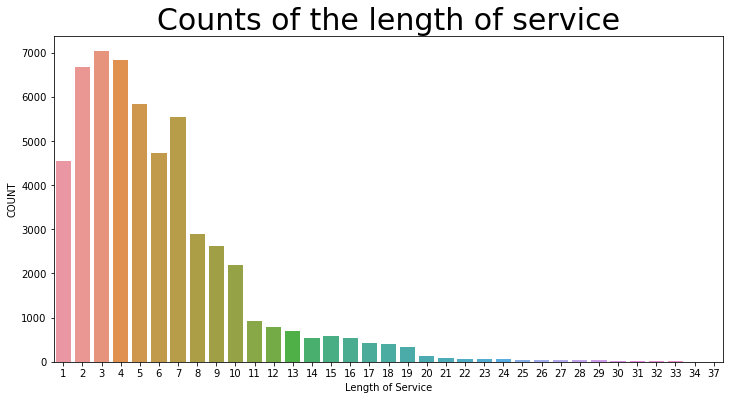

In [15]:
plt.figure(figsize=(12, 6))
sns.countplot(train['length_of_service'])
plt.title('Counts of the length of service', fontsize=30)
plt.xlabel('Length of Service')
plt.ylabel('COUNT')
plt.show()

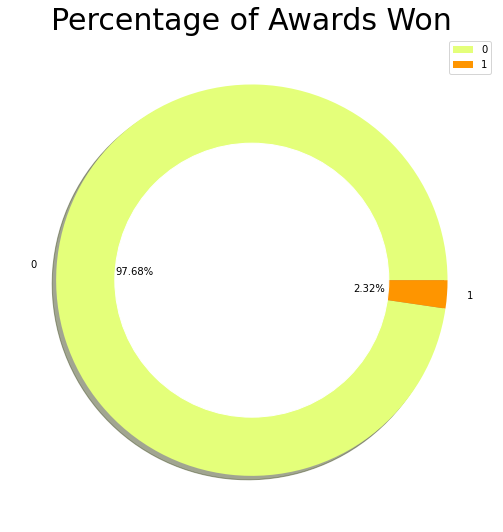

In [16]:
size = train['awards_won?'].value_counts()
labels = train['awards_won?'].unique()
colors = plt.cm.Wistia(np.linspace(0,5,7))

plt.figure(figsize=(9,9))
circle = plt.Circle((0, 0), radius=0.7, color='white')
plt.pie(size, colors = colors, labels = labels, shadow = True, autopct = '%.2f%%')
p = plt.gcf()
p.gca().add_artist(circle)
plt.title('Percentage of Awards Won', fontsize=30)
plt.legend();

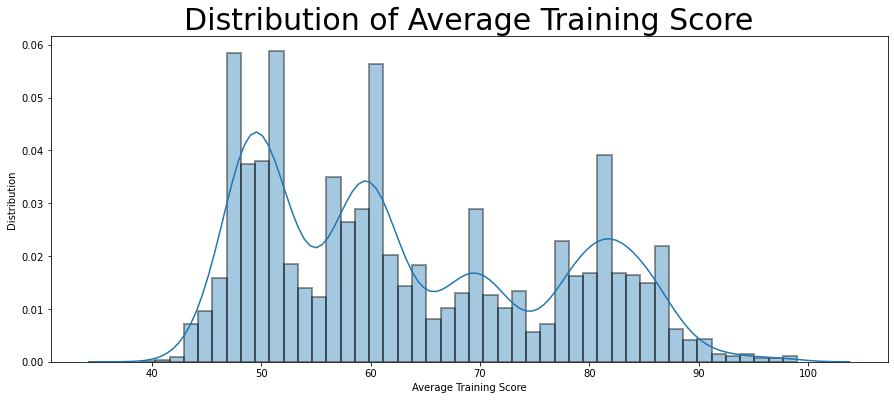

In [17]:
plt.figure(figsize=(15, 6))
sns.distplot(train['avg_training_score'], hist_kws=dict(edgecolor='black', linewidth=2))
plt.title('Distribution of Average Training Score', fontsize=30)
plt.xlabel('Average Training Score')
plt.ylabel('Distribution')
plt.show()

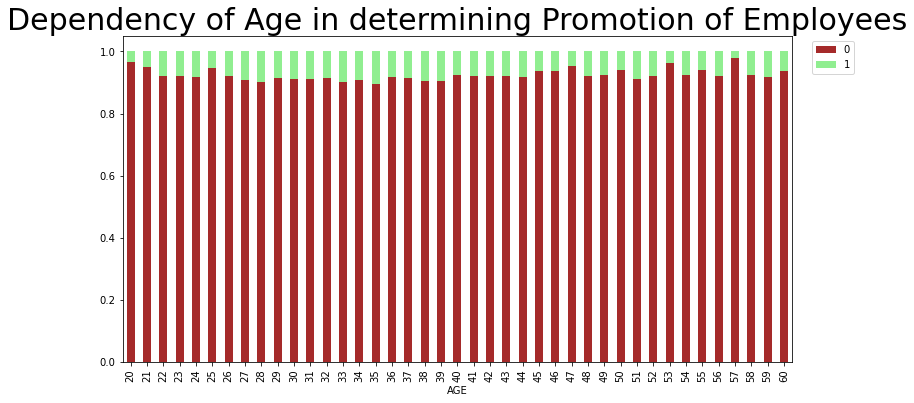

In [18]:
data=pd.crosstab(train['age'], train['is_promoted'])
data.div(data.sum(1).astype(float), axis=0).plot(stacked=True, kind='bar', color=['brown', 'lightgreen'], figsize=(12, 6))
plt.title('Dependency of Age in determining Promotion of Employees', fontsize=30)
plt.xlabel('AGE')
plt.legend(bbox_to_anchor=(0.5, 0., 0.6, 1.0))
plt.show()

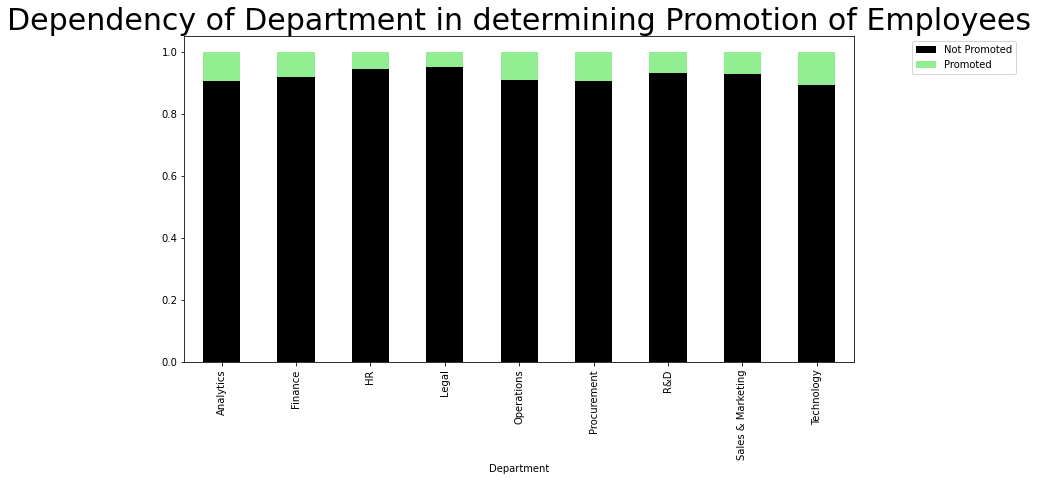

In [19]:
labels = ['Not Promoted', 'Promoted']
data=pd.crosstab(train['department'], train['is_promoted'])
data.div(data.sum(1).astype(float), axis=0).plot(stacked=True, kind='bar', color=['black', 'lightgreen'], figsize=(12, 6))
plt.title('Dependency of Department in determining Promotion of Employees', fontsize=30)
plt.xlabel('Department')
plt.legend(labels, bbox_to_anchor=(0.5, 0., 0.75, 1.0))
plt.show()

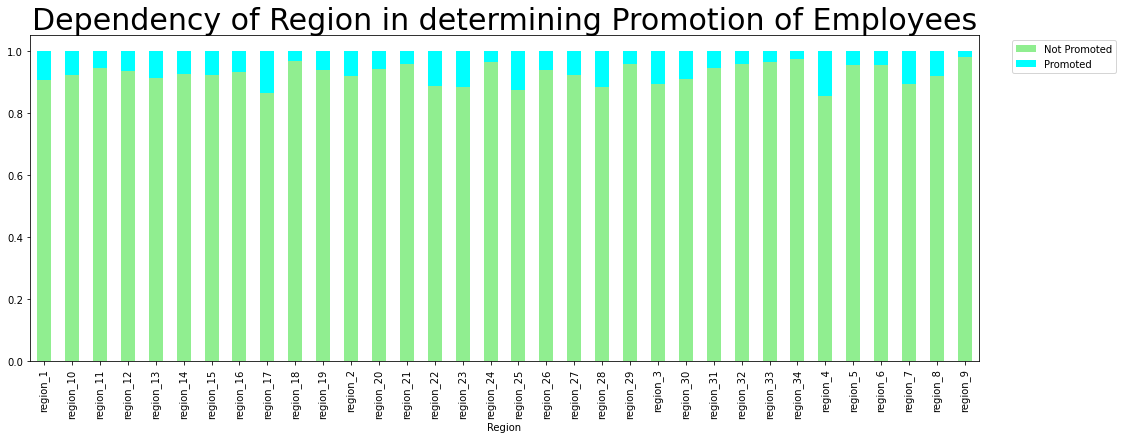

In [20]:
labels = ['Not Promoted', 'Promoted']
data = pd.crosstab(train['region'], train['is_promoted'])
data.div(data.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['lightgreen', 'cyan'], figsize=(17, 6))
plt.title('Dependency of Region in determining Promotion of Employees', fontsize=30)
plt.xlabel('Region')
plt.legend(labels, bbox_to_anchor=(0.5, 0., 0.65, 1.0))
plt.show()

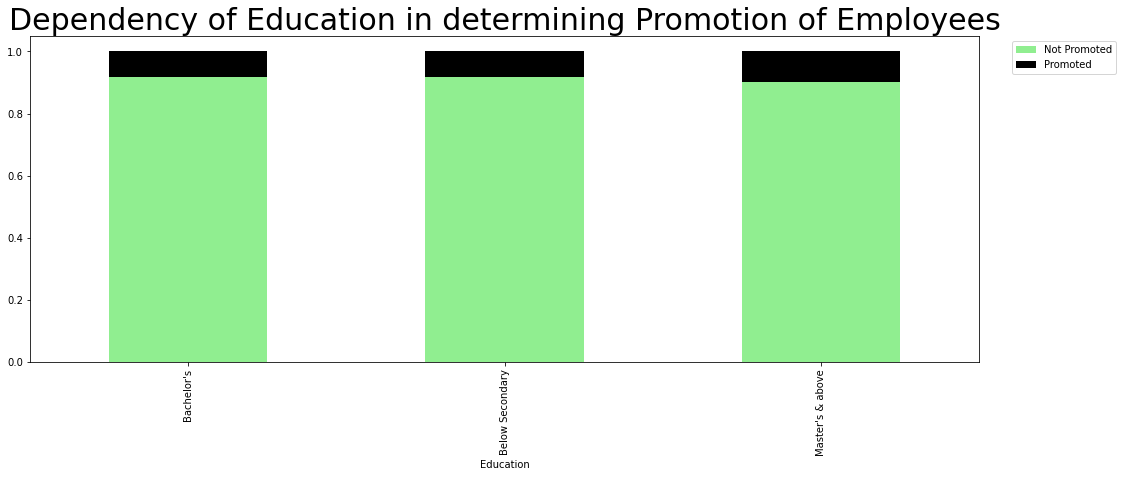

In [21]:
labels = ['Not Promoted', 'Promoted']
data = pd.crosstab(train['education'], train['is_promoted'])
data.div(data.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['lightgreen', 'black'], figsize=(17, 6))
plt.title('Dependency of Education in determining Promotion of Employees', fontsize=30)
plt.xlabel('Education')
plt.legend(labels, bbox_to_anchor=(0.5, 0., 0.65, 1.0))
plt.show()

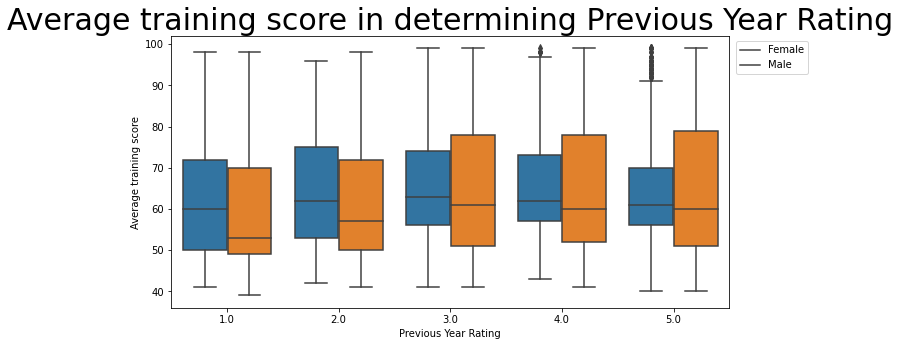

In [22]:
labels = ['Female', 'Male']
plt.figure(figsize=(10,5))
sns.boxplot(train['previous_year_rating'], train['avg_training_score'], hue=train['gender'])
plt.title('Average training score in determining Previous Year Rating', fontsize=30)
plt.xlabel('Previous Year Rating')
plt.ylabel('Average training score')
plt.legend(labels, bbox_to_anchor=(0.5, 0., 0.65, 1.0))
plt.show()

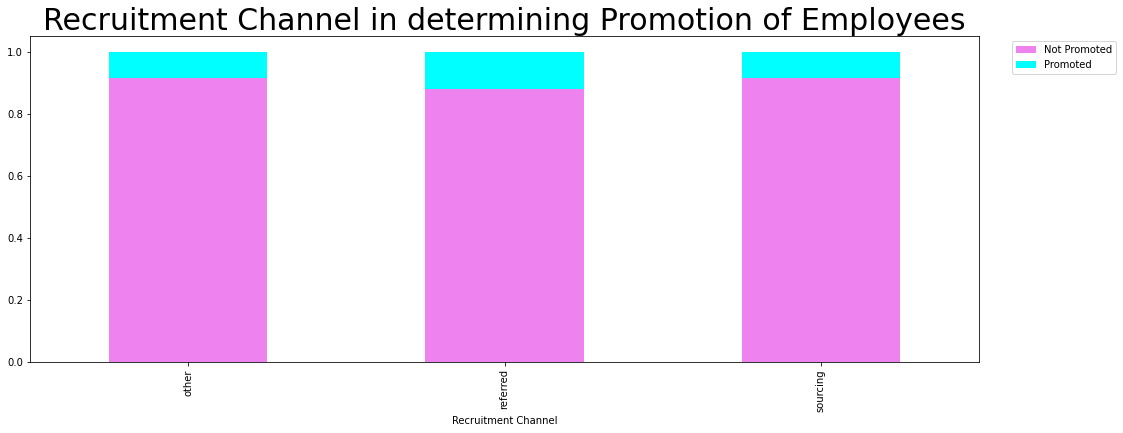

In [23]:
labels = ['Not Promoted', 'Promoted']
data = pd.crosstab(train['recruitment_channel'], train['is_promoted'])
data.div(data.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['violet', 'cyan'], figsize=(17, 6))
plt.title('Recruitment Channel in determining Promotion of Employees', fontsize=30)
plt.xlabel('Recruitment Channel')
plt.legend(labels, bbox_to_anchor=(0.5, 0., 0.65, 1.0))
plt.show()

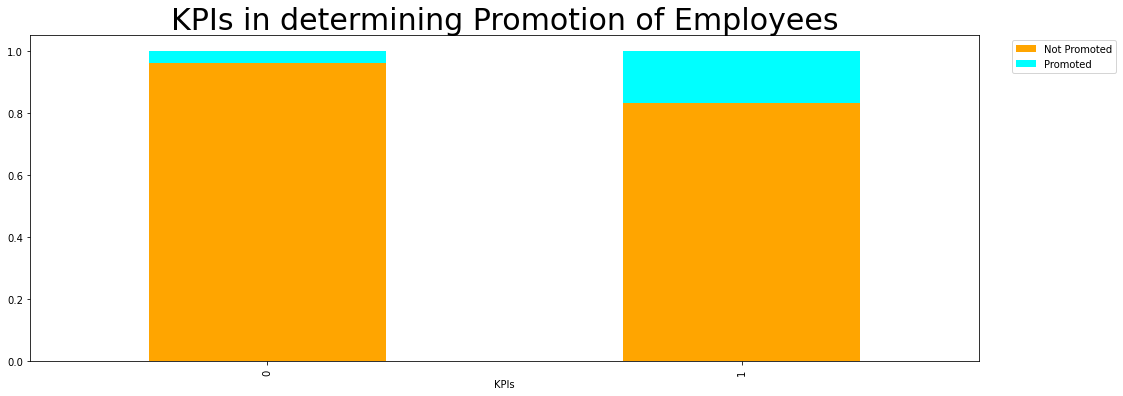

In [24]:
labels = ['Not Promoted', 'Promoted']
data = pd.crosstab(train['KPIs_met >80%'], train['is_promoted'])
data.div(data.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['orange', 'cyan'], figsize=(17, 6))
plt.title('KPIs in determining Promotion of Employees', fontsize=30)
plt.xlabel('KPIs')
plt.legend(labels, bbox_to_anchor=(0.5, 0., 0.65, 1.0))
plt.show()

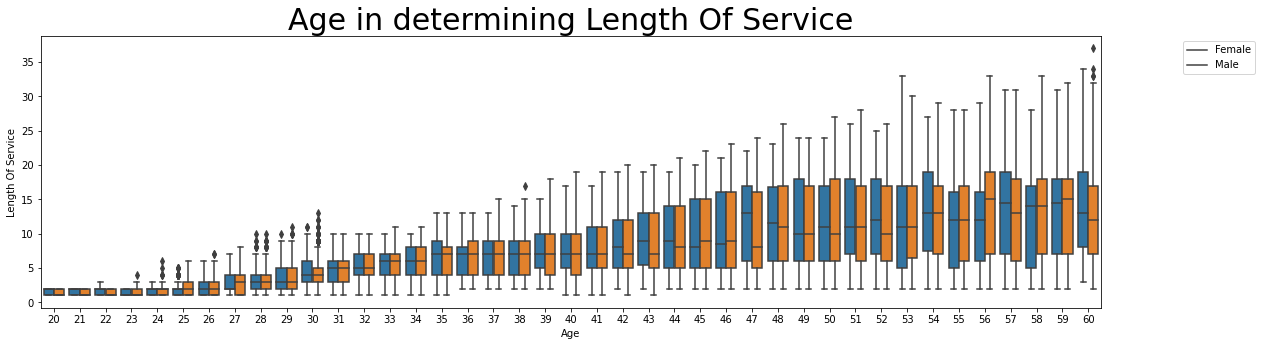

In [25]:
labels = ['Female', 'Male']
plt.figure(figsize=(19,5))
sns.boxplot(train['age'], train['length_of_service'], hue=train['gender'])
plt.title('Age in determining Length Of Service', fontsize=30)
plt.xlabel('Age')
plt.ylabel('Length Of Service')
plt.legend(labels, bbox_to_anchor=(0.5, 0., 0.65, 1.0))
plt.show()

In [26]:
train.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [27]:
test.isnull().sum()

employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64

In [28]:
train['education'].value_counts()

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

In [29]:
train['previous_year_rating'].value_counts()

3.00    18618
5.00    11741
4.00     9877
1.00     6223
2.00     4225
Name: previous_year_rating, dtype: int64

In [30]:
train['education'] = train['education'].fillna(train['education'].mode()[0])
train['previous_year_rating'] = train['previous_year_rating'].fillna(1)

test['education'] = test['education'].fillna(test['education'].mode()[0])
test['previous_year_rating'] = test['previous_year_rating'].fillna(1)

In [31]:
cols = ['department', 'region', 'education', 'gender', 'recruitment_channel']
train = pd.get_dummies(train, columns=cols)
test = pd.get_dummies(test, columns=cols)

In [32]:
ID_COL, TARGET_COL = 'employee_id', 'is_promoted'
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]

In [33]:
df = pd.concat([train, test], axis=0).reset_index(drop = True)
df.shape

(78298, 60)

In [34]:
df.head()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_1,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,65438,1,35,5.00,8,1,0,49,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1
1,65141,1,30,5.00,4,0,0,60,0.00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
2,7513,1,34,3.00,7,0,0,50,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
3,2542,2,39,1.00,10,0,0,50,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
4,48945,1,45,3.00,2,0,0,73,0.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0


In [35]:
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)
features = [c for c in train_proc.columns if c not in [ID_COL, TARGET_COL]]

In [36]:
trn, val = train_test_split(train_proc, test_size=0.2, random_state = 1, stratify = train_proc[TARGET_COL])

###### Input to our model will be the features
X_trn, X_val = trn[features], val[features]

###### Output of our model will be the TARGET_COL
y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

##### Features for the test data that we will be predicting
X_test = test_proc[features]

In [37]:
def run_clf_kfold(clf, train, test, features):

  N_SPLITS = 5

  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  folds = StratifiedKFold(n_splits = N_SPLITS)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# Scaling Data ################
    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)


    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn, y_trn)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict_proba(X_val)[:, 1]
    preds_test = clf.predict_proba(X_test)[:, 1]

    fold_score = f1_score(y_val, preds_val.round())
    print(f'\nF1 score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = f1_score(target, oofs.round())
  print(f'\n\nF1 score for oofs is {oofs_score}')

  return oofs, preds

In [38]:
target = train[TARGET_COL]

In [39]:
dt_params = {'class_weight': {0: 1, 1: 3},
             'criterion': 'gini',
             'max_depth': 10,
             'max_features': 0.8,
             'max_leaf_nodes': 32,
             'min_samples_split': 20,
             'random_state': 1
             }

clf = DecisionTreeClassifier(**dt_params)
        

dt_oofs, dt_preds = run_clf_kfold(clf, train_proc, test_proc, features)


------------- Fold 1 -------------

F1 score for validation set is 0.46333104866346814

------------- Fold 2 -------------

F1 score for validation set is 0.44695898161244696

------------- Fold 3 -------------

F1 score for validation set is 0.46827992151733155

------------- Fold 4 -------------

F1 score for validation set is 0.3945133899412149

------------- Fold 5 -------------

F1 score for validation set is 0.4726477024070022


F1 score for oofs is 0.4485213581599124


In [40]:
clf = LGBMClassifier()
lgb_oofs, lgb_preds = run_clf_kfold(clf, train_proc, test_proc, features)


------------- Fold 1 -------------

F1 score for validation set is 0.5156739811912227

------------- Fold 2 -------------

F1 score for validation set is 0.49095200629425656

------------- Fold 3 -------------

F1 score for validation set is 0.5046875000000001

------------- Fold 4 -------------

F1 score for validation set is 0.5268901013250196

------------- Fold 5 -------------

F1 score for validation set is 0.4976452119309262


F1 score for oofs is 0.5072055137844611


In [41]:
thresholds = np.arange(0, 100)/100
for thresh in thresholds:
  oofs_rounded = (lgb_oofs > thresh) * 1
  thresh_score = f1_score(target, oofs_rounded)
  print(f'Threshold {thresh}: {thresh_score}')

Threshold 0.0: 0.15697087901002085
Threshold 0.01: 0.29571959706377704
Threshold 0.02: 0.3162478143106936
Threshold 0.03: 0.3331999272330362
Threshold 0.04: 0.34194009095350847
Threshold 0.05: 0.3480371383441846
Threshold 0.06: 0.3539935090635637
Threshold 0.07: 0.3601257296811855
Threshold 0.08: 0.368803364343061
Threshold 0.09: 0.3794289799383405
Threshold 0.1: 0.3915253432140991
Threshold 0.11: 0.4007722792399147
Threshold 0.12: 0.41555151715402827
Threshold 0.13: 0.42998145600287135
Threshold 0.14: 0.44313547802446757
Threshold 0.15: 0.45579761068165847
Threshold 0.16: 0.46727828746177374
Threshold 0.17: 0.47364943003469356
Threshold 0.18: 0.48334817453250223
Threshold 0.19: 0.49230475097982984
Threshold 0.2: 0.49903209373408053
Threshold 0.21: 0.5083099503561408
Threshold 0.22: 0.5127214902317129
Threshold 0.23: 0.5162587205864964
Threshold 0.24: 0.5178637200736649
Threshold 0.25: 0.5198170731707317
Threshold 0.26: 0.5203908794788273
Threshold 0.27: 0.521136151486865
Threshold 0.2

In [42]:
def get_optimal_f1_thresh(target, oofs):
  thresholds = np.arange(0, 100)/100
  thresh_scores = []
  for thresh in thresholds:
    oofs_rounded = (lgb_oofs > thresh) * 1
    thresh_score = f1_score(target, oofs_rounded)
    thresh_scores.append(thresh_score)
  
  all_thresholds_and_scores = pd.Series(index = thresholds, data = thresh_scores)
  all_thresholds_and_scores.plot(figsize=(10, 6), fontsize=14)
  
  plt.xlabel('Threshold', fontsize=14)
  plt.ylabel('F1 Score', fontsize=14)

  return all_thresholds_and_scores.sort_values(ascending=False).index.values[0]

Optimal threhold is 0.27


0.521136151486865

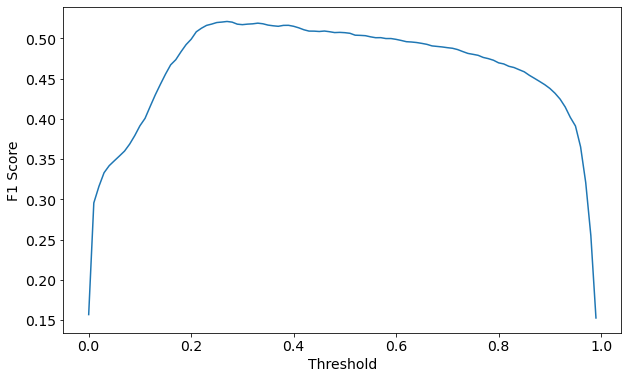

In [43]:
optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
f1_score(target, (lgb_oofs > optimal_thresh) * 1)

In [44]:
def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 10
  oofs = np.zeros(len(train_proc))
  preds = np.zeros((len(test_proc)))

  folds = StratifiedKFold(n_splits = N_SPLITS)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict_proba(X_val)[:, 1]
    preds_test = clf.predict_proba(X_test)[:, 1]

    fold_score = f1_score(y_val, preds_val.round())
    print(f'\nF1 score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = f1_score(target, oofs.round())
  print(f'\n\nF1 score for oofs is {oofs_score}')

  return oofs, preds


------------- Fold 1 -------------
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.162691
[200]	valid_0's binary_logloss: 0.160645
[300]	valid_0's binary_logloss: 0.160624
Early stopping, best iteration is:
[284]	valid_0's binary_logloss: 0.16038

F1 score for validation set is 0.5101721439749608

------------- Fold 2 -------------
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.163841
[200]	valid_0's binary_logloss: 0.162358
[300]	valid_0's binary_logloss: 0.162288
Early stopping, best iteration is:
[294]	valid_0's binary_logloss: 0.162264

F1 score for validation set is 0.5202492211838007

------------- Fold 3 -------------
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.169493
[200]	valid_0's binary_logloss: 0.167853
Early stopping, best iteration is:
[188]	valid_0's binary_logloss: 0.16774

F1 score for validation set is 0.4652665589660743

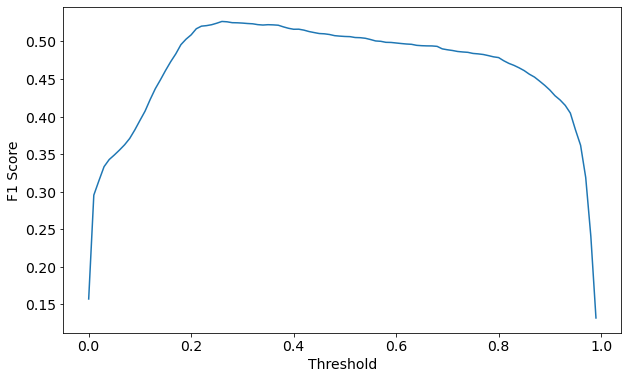

In [45]:
clf = LGBMClassifier(n_estimators = 1000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.76,
                        )
fit_params = {'verbose': 100, 'early_stopping_rounds': 100}

lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')


------------- Fold 1 -------------
[0]	validation_0-error:0.08557
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validation_0-error:0.05893
[400]	validation_0-error:0.05765
Stopping. Best iteration:
[332]	validation_0-error:0.05765


F1 score for validation set is 0.501577287066246

------------- Fold 2 -------------
[0]	validation_0-error:0.08539
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validation_0-error:0.05692
[400]	validation_0-error:0.05638
Stopping. Best iteration:
[304]	validation_0-error:0.05565


F1 score for validation set is 0.5226917057902973

------------- Fold 3 -------------
[0]	validation_0-error:0.08520
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validation_0-error:0.06258
[400]	validation_0-error:0.06003
[600]	validation_0-error:0.05984
[800]	validation_0-error:0.05966
Stopping. Best iteration:
[688]	validation_0-error:0.05930


F1 score for validation set is 0.4849445324881141

-

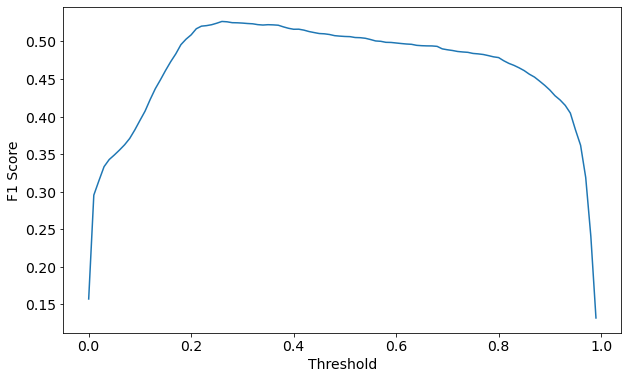

In [46]:
clf = XGBClassifier(n_estimators = 1000,
                    max_depth = 6,
                    learning_rate = 0.05,
                    colsample_bytree = 0.5,
                    random_state=1452,
                    )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, xgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (xgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')


------------- Fold 1 -------------
Training until validation scores don't improve for 1000 rounds
[200]	valid_0's binary_logloss: 0.216083
[400]	valid_0's binary_logloss: 0.194007
[600]	valid_0's binary_logloss: 0.182932
[800]	valid_0's binary_logloss: 0.176141
[1000]	valid_0's binary_logloss: 0.1714
[1200]	valid_0's binary_logloss: 0.16881
[1400]	valid_0's binary_logloss: 0.166508
[1600]	valid_0's binary_logloss: 0.165169
[1800]	valid_0's binary_logloss: 0.164313
[2000]	valid_0's binary_logloss: 0.163858
[2200]	valid_0's binary_logloss: 0.163451
[2400]	valid_0's binary_logloss: 0.163093
[2600]	valid_0's binary_logloss: 0.163008
[2800]	valid_0's binary_logloss: 0.162932
[3000]	valid_0's binary_logloss: 0.162825
Did not meet early stopping. Best iteration is:
[2993]	valid_0's binary_logloss: 0.162824

F1 score for validation set is 0.4921135646687697

------------- Fold 2 -------------
Training until validation scores don't improve for 1000 rounds
[200]	valid_0's binary_logloss: 0.2179

[1800]	valid_0's binary_logloss: 0.165749
[2000]	valid_0's binary_logloss: 0.165067
[2200]	valid_0's binary_logloss: 0.164565
[2400]	valid_0's binary_logloss: 0.164185
[2600]	valid_0's binary_logloss: 0.163994
[2800]	valid_0's binary_logloss: 0.163811
[3000]	valid_0's binary_logloss: 0.163774
Did not meet early stopping. Best iteration is:
[2887]	valid_0's binary_logloss: 0.163715

F1 score for validation set is 0.49765258215962443


F1 score for oofs is 0.5061902523115499
Optimal threhold is 0.3
Optimized F1 is 0.5279255319148937


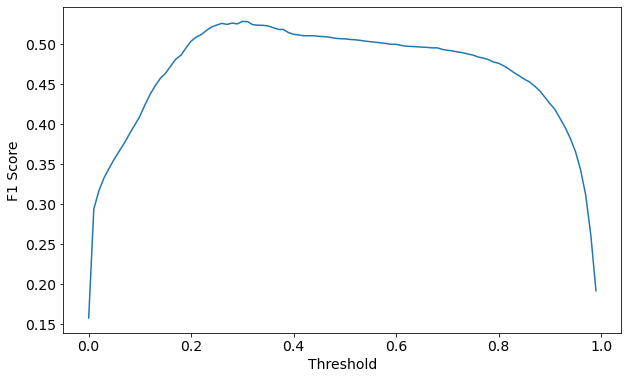

In [47]:
clf = LGBMClassifier(n_estimators = 3000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.38,
                        reg_alpha = 1,
                        reg_lambda = 1,
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 1000}
lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

In [48]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1

In [49]:
submission['is_promoted'] = lgb_preds_rounded
submission.to_csv('sample_submission.csv', index=False)